In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/best-artworks-of-all-time/artists.csv
/kaggle/input/best-artworks-of-all-time/resized/resized/Peter_Paul_Rubens_132.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Albrecht_Dürer_59.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Andrei_Rublev_21.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Vincent_van_Gogh_586.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Peter_Paul_Rubens_9.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Vincent_van_Gogh_559.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Amedeo_Modigliani_169.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Vincent_van_Gogh_804.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Amedeo_Modigliani_71.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Frida_Kahlo_68.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Albrecht_Dürer_307.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Andy_Warhol_3

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from numpy.random import seed
from keras import regularizers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## data preprocessing

In [4]:
data_dir = '/kaggle/input/best-artworks-of-all-time/'
data = pd.read_csv('/kaggle/input/best-artworks-of-all-time/artists.csv')

In [5]:
genre_df = data.groupby('genre')['paintings'].sum().reset_index(name='Count')

In [6]:
genre_df[genre_df['Count']>=150].reset_index().sort_values(by='Count', ascending = False)

,index,genre,Count
7,10,Impressionism,1370
11,16,Post-Impressionism,1048
9,14,Northern Renaissance,680
0,1,Baroque,586
1,3,Cubism,439
13,22,Romanticism,388
17,30,"Symbolism,Post-Impressionism",311
12,17,Primitivism,309
5,8,High Renaissance,301
8,11,"Impressionism,Post-Impressionism",277


In [7]:
genre = np.array(genre_df[genre_df['Count']>=200].reset_index()['genre'])
len(genre)

12

In [8]:
genre = ['Baroque', 'Cubism', 'High Renaissance',
        'Impressionism', 'Expressionism', 'Northern Renaissance', 'Pop Art', 
         'Post-Impressionism', 'Primitivism', 'Romanticism', 'Surrealism', 'Symbolism']

In [9]:
from collections import defaultdict

genre_artist = defaultdict(list)
for g in genre:
    for i in range(len(data)):
        if data['genre'].iloc[i] == g:
            genre_artist[g].append(data['name'].iloc[i])

In [10]:
genre_artist

defaultdict(list,
            {'Baroque': ['Peter Paul Rubens',
              'Caravaggio',
              'Diego Velazquez',
              'Rembrandt'],
             'Cubism': ['Pablo Picasso'],
             'High Renaissance': ['Leonardo da Vinci',
              'Raphael',
              'Michelangelo'],
             'Impressionism': ['Claude Monet',
              'Pierre-Auguste Renoir',
              'Alfred Sisley',
              'Edgar Degas'],
             'Expressionism': ['Amedeo Modigliani'],
             'Northern Renaissance': ['Hieronymus Bosch',
              'Albrecht Dürer',
              'Pieter Bruegel',
              'Jan van Eyck'],
             'Pop Art': ['Andy Warhol'],
             'Post-Impressionism': ['Vincent van Gogh',
              'Henri de Toulouse-Lautrec',
              'Paul Cezanne',
              'Georges Seurat'],
             'Primitivism': ['Marc Chagall', 'Henri Rousseau'],
             'Romanticism': ['Francisco Goya',
              'William Turn

In [11]:
!mkdir image_dir
for g in genre:
    gg = g.replace(" ", "_")
    print(gg)
    !mkdir image_dir/$gg
    for i in genre_artist[g]:
        name = i.replace(" ", "_")
        if name == 'Albrecht_Dürer':
            !cp -r /kaggle/input/best-artworks-of-all-time/images/images/Albrecht_Du╠êrer/* 'image_dir/'$gg
        else:
            !cp -r '/kaggle/input/best-artworks-of-all-time/images/images/'$name/* 'image_dir/'$gg

Baroque
Cubism
High_Renaissance
Impressionism
Expressionism
Northern_Renaissance
Pop_Art
Post-Impressionism
Primitivism
Romanticism
Surrealism
Symbolism


In [12]:
!mv image_dir/High_Renaissance 'image_dir/High Renaissance'
!mv image_dir/Northern_Renaissance 'image_dir/Northern Renaissance'
!mv image_dir/Pop_Art 'image_dir/Pop Art'

In [13]:
genre_df = data.groupby('genre')['paintings'].sum().reset_index(name='Count')
genre_df = genre_df[genre_df['genre'].isin(genre)].reset_index()
genre_df = genre_df.drop(['index'],axis = 1)
genre_df

,genre,Count
0,Baroque,586
1,Cubism,439
2,Expressionism,193
3,High Renaissance,301
4,Impressionism,1370
5,Northern Renaissance,680
6,Pop Art,181
7,Post-Impressionism,1048
8,Primitivism,309
9,Romanticism,388


### add class weight

In [14]:
genre_df['class_weight'] = genre_df.Count.sum() / (genre_df.shape[0] * genre_df.Count)
artists_genre =np.array(genre_df['genre'])  
artists_genre=np.unique(artists_genre)
class_weights = genre_df['class_weight'].to_dict()
class_weights

{0: 0.8400170648464164,
 1: 1.1212984054669703,
 2: 2.550518134715026,
 3: 1.6353820598006645,
 4: 0.3593065693430657,
 5: 0.7238970588235294,
 6: 2.7196132596685083,
 7: 0.46970419847328243,
 8: 1.593042071197411,
 9: 1.2686855670103092,
 10: 2.04253112033195,
 11: 2.878654970760234}

### check path

In [15]:
images_dir = 'image_dir'
artists_dirs = os.listdir(images_dir)

In [16]:
for name in artists_genre:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> image_dir/Baroque
Found --> image_dir/Cubism
Found --> image_dir/Expressionism
Found --> image_dir/High Renaissance
Found --> image_dir/Impressionism
Found --> image_dir/Northern Renaissance
Found --> image_dir/Pop Art
Found --> image_dir/Post-Impressionism
Found --> image_dir/Primitivism
Found --> image_dir/Romanticism
Found --> image_dir/Surrealism
Found --> image_dir/Symbolism


In [17]:
artists_temp = genre_df.copy()

## data augmentation

In [18]:

# Augment data
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_temp.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   rotation_range=30,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_genre.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_genre.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 4730 images belonging to 12 classes.
Found 1177 images belonging to 12 classes.
Total number of batches = 147 and 36


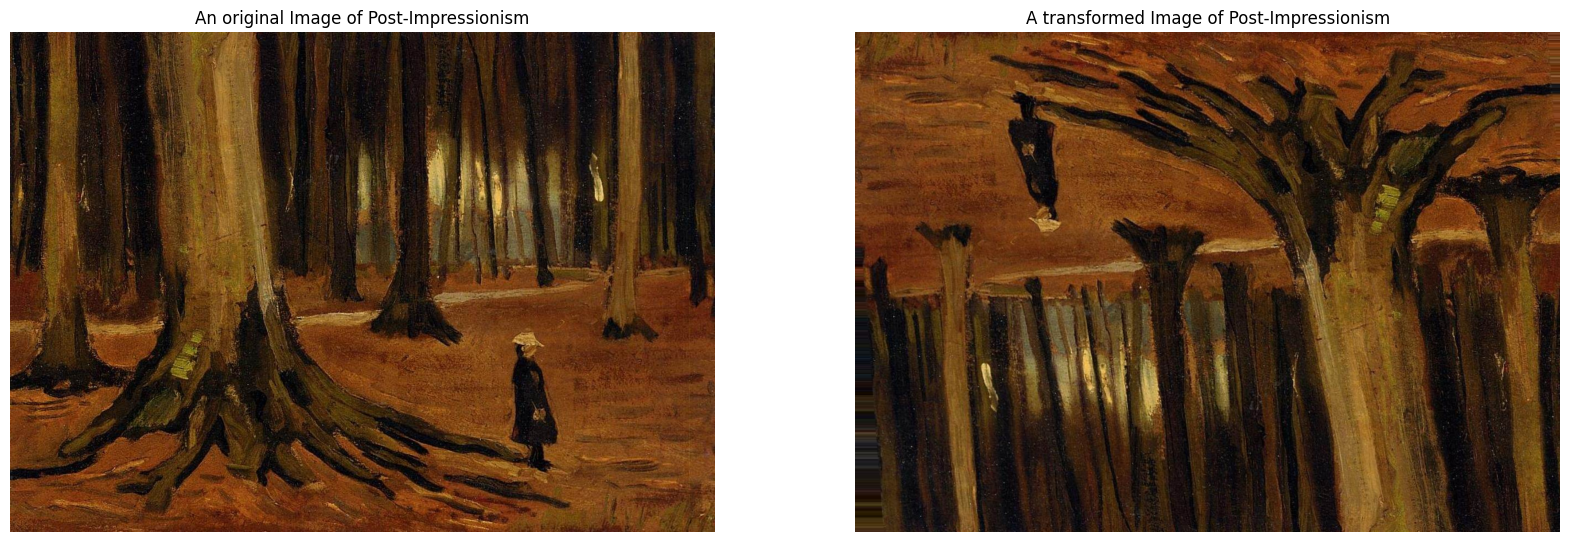

In [19]:

# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_genre)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

## resnet


In [20]:
# Load pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

94765736/94765736 [==============================] - 0s 0us/step


In [21]:

# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [22]:
optimizer = AdamW(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [23]:
n_epoch = 30

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [24]:
history1 = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                               use_multiprocessing=True,
                              callbacks=[reduce_lr],
                              workers=16,
                            class_weight=class_weights
                             )

/tmp/ipykernel_42/2352353094.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,


Epoch 1/30
147/147 [==============================] - 109s 405ms/step - loss: 2.1205 - accuracy: 0.2373 - val_loss: 7.6321 - val_accuracy: 0.0312 - lr: 0.0010
Epoch 2/30
147/147 [==============================] - 66s 417ms/step - loss: 1.9280 - accuracy: 0.3155 - val_loss: 2.7182 - val_accuracy: 0.1146 - lr: 0.0010
Epoch 3/30
147/147 [==============================] - 65s 416ms/step - loss: 1.6568 - accuracy: 0.4117 - val_loss: 5.1394 - val_accuracy: 0.0278 - lr: 0.0010
Epoch 4/30
147/147 [==============================] - 63s 405ms/step - loss: 1.4966 - accuracy: 0.4651 - val_loss: 3.7046 - val_accuracy: 0.0399 - lr: 0.0010
Epoch 5/30
147/147 [==============================] - 64s 409ms/step - loss: 1.3873 - accuracy: 0.5179 - val_loss: 3.9024 - val_accuracy: 0.0417 - lr: 0.0010
Epoch 6/30
147/147 [==============================] - 66s 427ms/step - loss: 1.3014 - accuracy: 0.5549 - val_loss: 3.4752 - val_accuracy: 0.1649 - lr: 0.0010
Epoch 7/30
147/147 [==============================]

In [25]:
# Freeze core ResNet layers and train again 
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = AdamW(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 100
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

/tmp/ipykernel_42/1768557267.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,


Epoch 1/100
147/147 [==============================] - 79s 412ms/step - loss: 0.2124 - accuracy: 0.9276 - val_loss: 2.9531 - val_accuracy: 0.2109 - lr: 0.0010
Epoch 2/100
147/147 [==============================] - 63s 403ms/step - loss: 0.1796 - accuracy: 0.9440 - val_loss: 1.7401 - val_accuracy: 0.4844 - lr: 0.0010
Epoch 3/100
147/147 [==============================] - 63s 404ms/step - loss: 0.1764 - accuracy: 0.9419 - val_loss: 2.4117 - val_accuracy: 0.2986 - lr: 0.0010
Epoch 4/100
147/147 [==============================] - 62s 394ms/step - loss: 0.1663 - accuracy: 0.9525 - val_loss: 1.6147 - val_accuracy: 0.5226 - lr: 0.0010
Epoch 5/100
147/147 [==============================] - 63s 401ms/step - loss: 0.1592 - accuracy: 0.9525 - val_loss: 2.0982 - val_accuracy: 0.3845 - lr: 0.0010
Epoch 6/100
147/147 [==============================] - 63s 395ms/step - loss: 0.1764 - accuracy: 0.9444 - val_loss: 1.7926 - val_accuracy: 0.4557 - lr: 0.0010
Epoch 7/100
147/147 [=========================

## history

In [27]:
# Merge history1 and history2
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['accuracy'] = history1.history['accuracy'] + history2.history['accuracy']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_accuracy'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
# history['learning_rate'] = history1.history['learning_rate'] + history2.history['learning_rate']

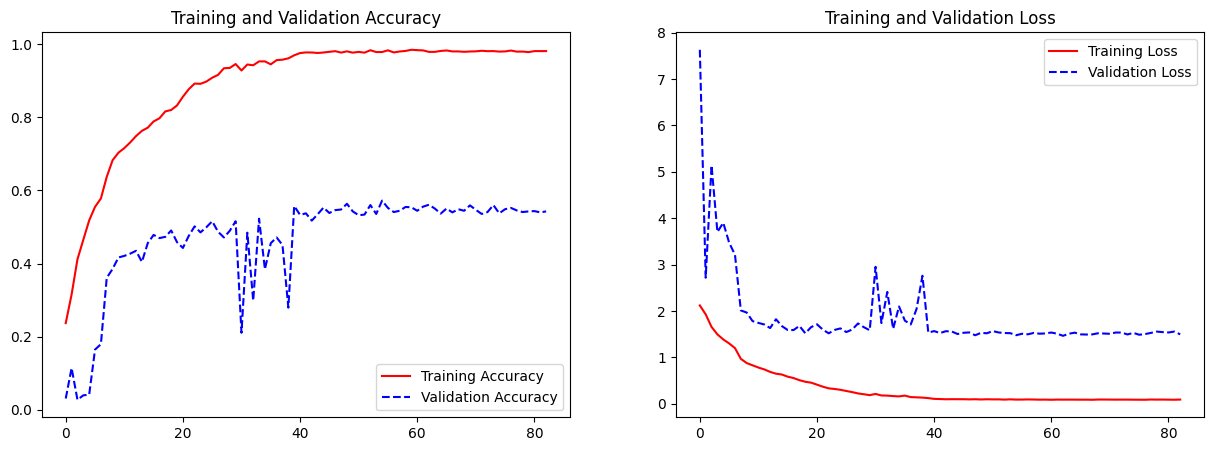

In [28]:

# Plot the training graph
def plot_training(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(loss))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

## result

In [29]:
# Prediction accuracy on train data
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =%.3f"%score[1])

/tmp/ipykernel_42/3410001329.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(train_generator, verbose=1)


148/148 [==============================] - 76s 513ms/step - loss: 0.1178 - accuracy: 0.9884
Prediction accuracy on train data =0.988


In [30]:
# Prediction accuracy on CV data
score = model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on CV data =%.3f"%score[1])

/tmp/ipykernel_42/3290181623.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(valid_generator, verbose=1)


37/37 [==============================] - 19s 505ms/step - loss: 1.5027 - accuracy: 0.5565
Prediction accuracy on CV data =0.556


1/1 [==============================] - 0s 31ms/step


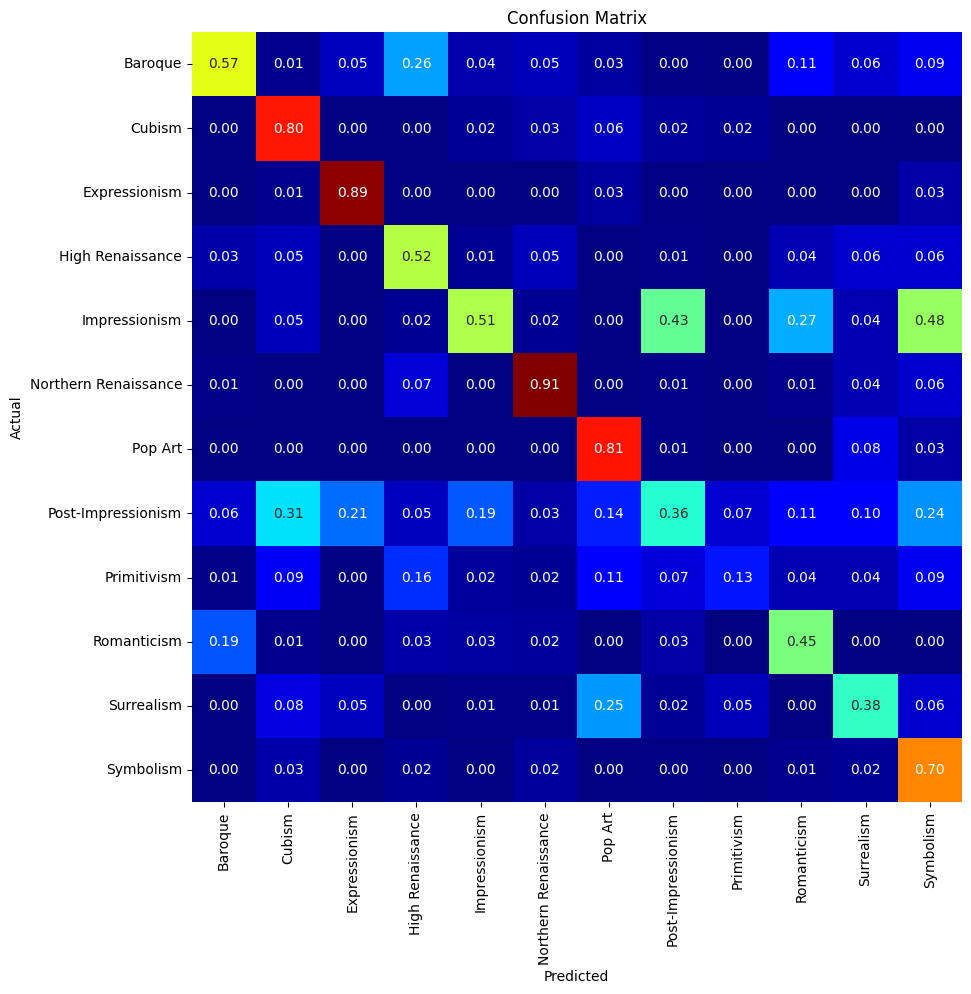

Classification Report:
                      precision    recall  f1-score   support

             Baroque       0.65      0.57      0.61       116
              Cubism       0.55      0.80      0.65        86
       Expressionism       0.74      0.89      0.81        38
    High Renaissance       0.46      0.52      0.49        58
       Impressionism       0.61      0.51      0.56       268
Northern Renaissance       0.79      0.91      0.84       129
             Pop Art       0.57      0.81      0.67        36
  Post-Impressionism       0.37      0.36      0.36       204
         Primitivism       0.50      0.13      0.21        61
         Romanticism       0.44      0.45      0.44        75
          Surrealism       0.45      0.38      0.41        48
           Symbolism       0.38      0.70      0.49        33

            accuracy                           0.55      1152
           macro avg       0.54      0.58      0.54      1152
        weighted avg       0.55      0.55    

In [31]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists_genre

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_genre))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)